In [ ]:
import os
import sys


from utils.db import init_db
from utils.data_cleaning import clean_data


NameError: name '__file__' is not defined

In [2]:
merged_df.head()

,id_x,booking_id,total_adult,total_children,room_id,room_size,room_view,room_type,total_price,id_y,stay_duration,id,max_occupancy
0,8766772,7387509,2,0,58974,70.0,city_view,cottage,302.05,7387509,3.0,58974,5
1,8645284,7283854,2,0,42345,12.0,city_view,room,63.00,7283854,1.0,42345,3
2,8668410,7303558,2,0,28729,55.0,city_view,apartment,576.00,7303558,4.0,28729,4
3,8049621,6778357,2,0,64038,26.0,city_view,room,93.50,6778357,1.0,64038,3
4,8786466,7404311,2,0,31784,0.0,city_view,room,62.00,7404311,1.0,31784,2


In [3]:
# Create features
merged_df['daily_rate'] = merged_df['total_price'] / merged_df['stay_duration']
merged_df['has_view_flag'] = merged_df['room_view'].apply(lambda x: 1 if pd.notnull(x) and x != '' else 0)
merged_df['is_suite_flag'] = merged_df['room_type'].astype(str).str.lower().str.contains('suite').astype(int)

# Aggregate per room
room_features = merged_df.groupby('room_id').agg(
    max_occupancy=('max_occupancy', 'max'),
    has_view=('has_view_flag', 'max'),
    is_suite=('is_suite_flag', 'max'),
    avg_size=('room_size', 'mean'),
    avg_historical_adr=('daily_rate', 'mean')
).reset_index()

# Handle missing values (impute median for avg_size)
median_size = room_features['avg_size'].median()
room_features['avg_size'] = room_features['avg_size'].fillna(median_size)
room_features['avg_historical_adr'] = room_features['avg_historical_adr'].fillna(0)

print(f"Feature Engineering complete. Rooms analyzed: {len(room_features)}")
print(room_features.head())

# === 0) helpers: report basic diagnostics ===
def cluster_size_report(labels):
    s = pd.Series(labels).value_counts().sort_index()
    return s

def tiny_clusters(labels, threshold=5):
    s = cluster_size_report(labels)
    return s[s <= threshold]

# Quick outlier checks
print("room_features: n_rows", len(room_features))
print("avg_historical_adr summary:")
print(room_features['avg_historical_adr'].describe())
print("avg_size summary:")
print(room_features['avg_size'].describe())


Feature Engineering complete. Rooms analyzed: 10178
   room_id  max_occupancy  has_view  is_suite  avg_size  avg_historical_adr
0      560              2         1         0      40.0          157.646872
1     1753              2         0         0      40.0           56.113344
2     1754              4         1         0      45.0           88.684547
3     1755              1         0         0      25.0           44.189618
4     1756              2         0         0      40.0           52.851573
room_features: n_rows 10178
avg_historical_adr summary:
count    1.017800e+04
mean     2.877100e+02
std      1.585864e+04
min      0.000000e+00
25%      7.263893e+01
50%      1.017376e+02
75%      1.450000e+02
max      1.600000e+06
Name: avg_historical_adr, dtype: float64
avg_size summary:
count    10178.000000
mean        59.339728
std        407.160919
min          0.000000
25%          7.000000
50%         27.381720
75%         62.000000
max      35000.000000
Name: avg_size, dtype: fl

Cluster Assignments:
tier
3    6886
1    2785
4     496
2       6
6       4
5       1
Name: count, dtype: int64

Cluster Centroids (Average Attributes):
          avg_size  max_occupancy  has_view  is_suite  avg_historical_adr
tier                                                                     
1        23.681976       3.219749  0.000000       0.0          102.886472
2      7333.333333      10.333333  0.833333       0.0          334.767863
3        45.517297       3.716091  1.000000       0.0          353.381167
4       292.424087      14.195565  0.925403       0.0          408.486445
5     35000.000000       8.000000  1.000000       0.0          586.441215
6       132.750000     135.000000  0.500000       0.0          796.628093


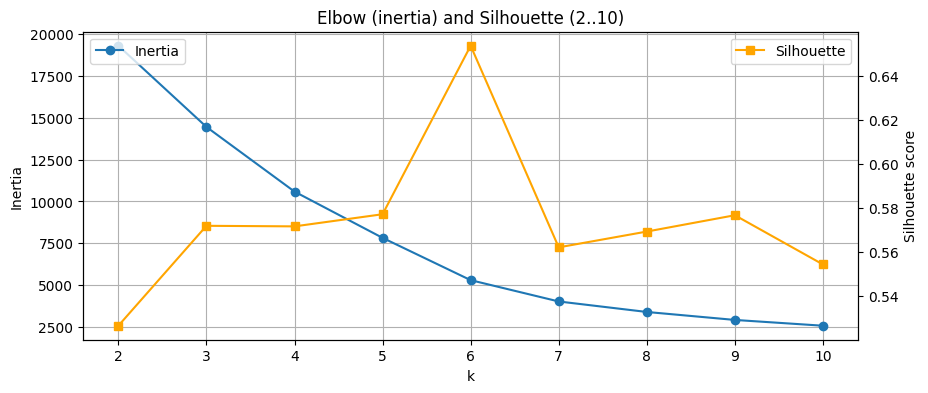

In [4]:
# Step 2: K-Means Clustering

# Select features for clustering (exclude price to avoid target leakage)
features = ['avg_size', 'max_occupancy', 'has_view', 'is_suite']
X = room_features[features]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Run K-Means
kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
room_features['cluster'] = kmeans.fit_predict(X_scaled)

# Label Clusters (Budget < Standard < Luxury based on price)
cluster_stats = room_features.groupby('cluster')['avg_historical_adr'].mean().sort_values()

# Map clusters to tiers (1-6)
label_map = {k: str(i+1) for i, k in enumerate(cluster_stats.index)}
room_features['tier'] = room_features['cluster'].map(label_map)

print("Cluster Assignments:")
print(room_features['tier'].value_counts())

# Verify clusters makes sense
print("\nCluster Centroids (Average Attributes):")
print(room_features.groupby('tier')[features + ['avg_historical_adr']].mean().sort_values('avg_historical_adr'))

# === 1) Optional preprocessing tweaks (winsorize / log) ===
rf = room_features.copy()

# Winsorize price
rf['adr_winsor'] = mstats.winsorize(rf['avg_historical_adr'], limits=[0.01, 0.01])

# Log transform
rf['log_adr'] = np.log1p(rf['adr_winsor'])
rf['log_size'] = np.log1p(rf['avg_size'])

rf[['log_adr','log_size']].describe().T

# === 2) Elbow + Silhouette sweep (k=2..10) ===
candidate_features = ['log_size', 'max_occupancy', 'has_view', 'is_suite']         # no price
X = rf[candidate_features].fillna(0).values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Ks = list(range(2, 11))
inertias = []
silhouettes = []

for k in Ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    try:
        from sklearn.metrics import silhouette_score
        silhouettes.append(silhouette_score(X_scaled, labels))
    except Exception:
        silhouettes.append(np.nan)

# Plot
fig, ax1 = plt.subplots(figsize=(10,4))
ax1.plot(Ks, inertias, '-o', label='Inertia')
ax1.set_xlabel('k')
ax1.set_ylabel('Inertia')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(Ks, silhouettes, '-s', color='orange', label='Silhouette')
ax2.set_ylabel('Silhouette score')

ax1.set_title('Elbow (inertia) and Silhouette (2..10)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()


/tmp/ipykernel_195093/2058208931.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(data['month_name'], rotation=45)
/tmp/ipykernel_195093/2058208931.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(data['month_name'], rotation=45)
/tmp/ipykernel_195093/2058208931.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(data['month_name'], rotation=45)


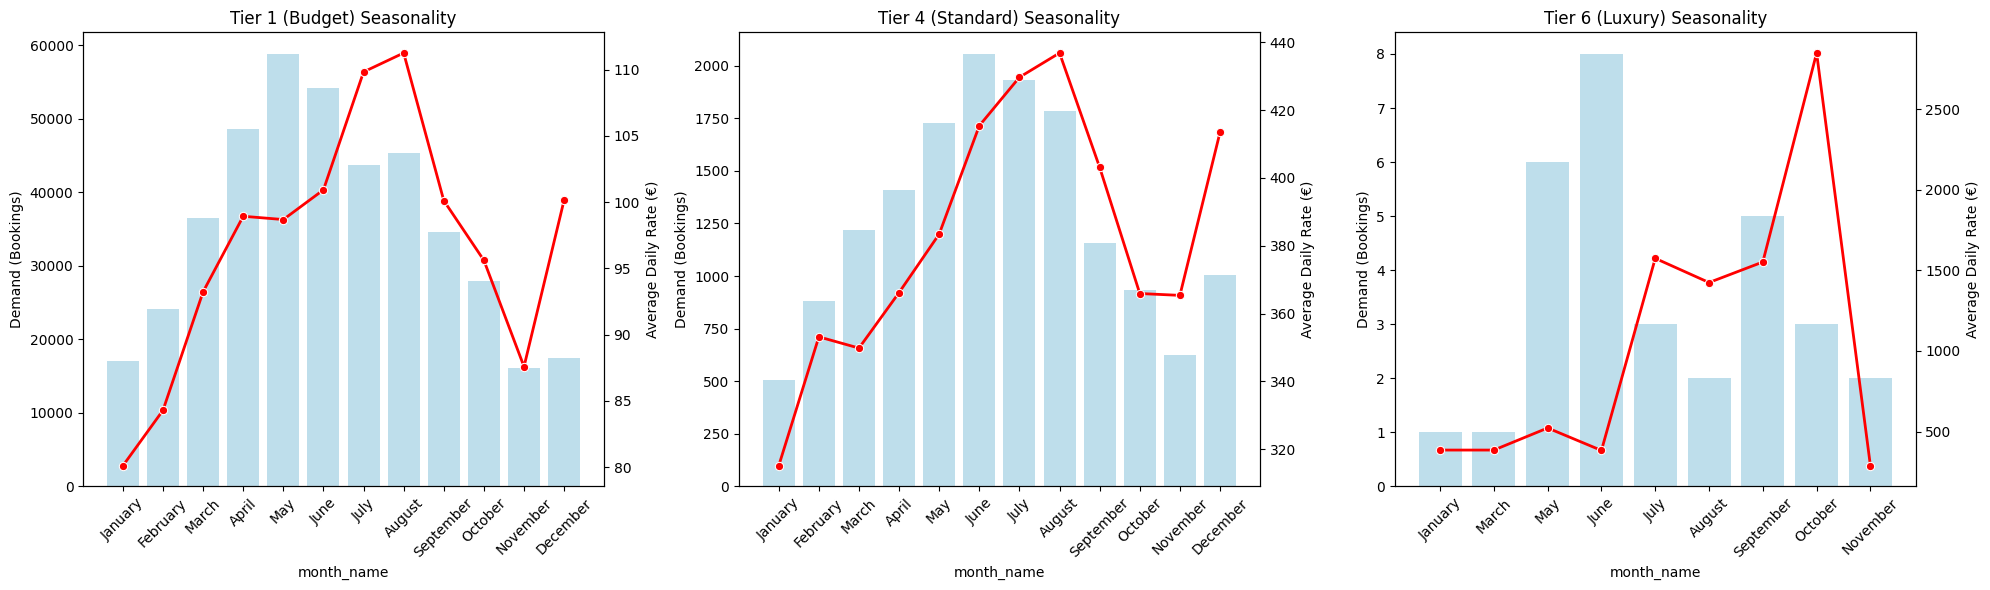

In [5]:
# Step 3: Controlled Analysis (Seasonality by Tier)

# We need base seasonality data first.
# Re-using merged_df which already has stay_duration and daily_rate

# Add month info to valid_bookings (source of merged_df)
# Note: We need to be careful with the merge. merged_df was an inner join of everything.
# The original query joined bookings and booked_rooms.

# Let's re-create the base seasonality using pandas
# bookings b JOIN booked_rooms br
seasonality_df = df_booked_rooms.merge(
    valid_bookings[['id', 'arrival_date', 'departure_date', 'stay_duration']], 
    left_on='booking_id', 
    right_on='id', 
    how='inner'
)

seasonality_df['daily_rate'] = seasonality_df['total_price'] / seasonality_df['stay_duration']
seasonality_df['month_num'] = seasonality_df['arrival_date'].dt.month
seasonality_df['month_name'] = seasonality_df['arrival_date'].dt.strftime('%B')

# Aggregate by room_id and month
base_seasonality = seasonality_df.groupby(['room_id', 'month_num', 'month_name']).agg(
    booking_count=('booking_id', 'count'),
    avg_adr=('daily_rate', 'mean')
).reset_index()

# Sort by month_num for cleaner plotting later
base_seasonality = base_seasonality.sort_values('month_num')

# Merge with tiers
controlled_df = base_seasonality.merge(room_features[['room_id', 'tier']], on='room_id', how='inner')

# Aggregate by Tier and Month
tier_seasonality = controlled_df.groupby(['tier', 'month_num', 'month_name']).agg({
    'booking_count': 'sum',
    'avg_adr': 'mean'
}).reset_index().sort_values(['tier', 'month_num'])

# Visualization
# Select 3 representative tiers (Low, Mid, High) or just plot all/subset
unique_tiers = sorted(tier_seasonality['tier'].unique())
# Let's pick 1, 3, 6 as Budget, Standard, Luxury proxies if available, or just the first 3
selected_tiers = [unique_tiers[0], unique_tiers[len(unique_tiers)//2], unique_tiers[-1]]
tier_labels = ['Budget', 'Standard', 'Luxury']

fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=False)

for i, tier in enumerate(selected_tiers):
    data = tier_seasonality[tier_seasonality['tier'] == tier]
    ax1 = axes[i]
    
    # Demand (Bar)
    sns.barplot(data=data, x='month_name', y='booking_count', color='skyblue', alpha=0.6, ax=ax1)
    ax1.set_title(f'Tier {tier} ({tier_labels[i]}) Seasonality')
    ax1.set_xticklabels(data['month_name'], rotation=45)
    ax1.set_ylabel('Demand (Bookings)')
    
    # Price (Line)
    ax2 = ax1.twinx()
    sns.lineplot(data=data, x='month_name', y='avg_adr', color='red', marker='o', ax=ax2, linewidth=2)
    ax2.set_ylabel('Average Daily Rate (€)')

plt.tight_layout()
plt.show()


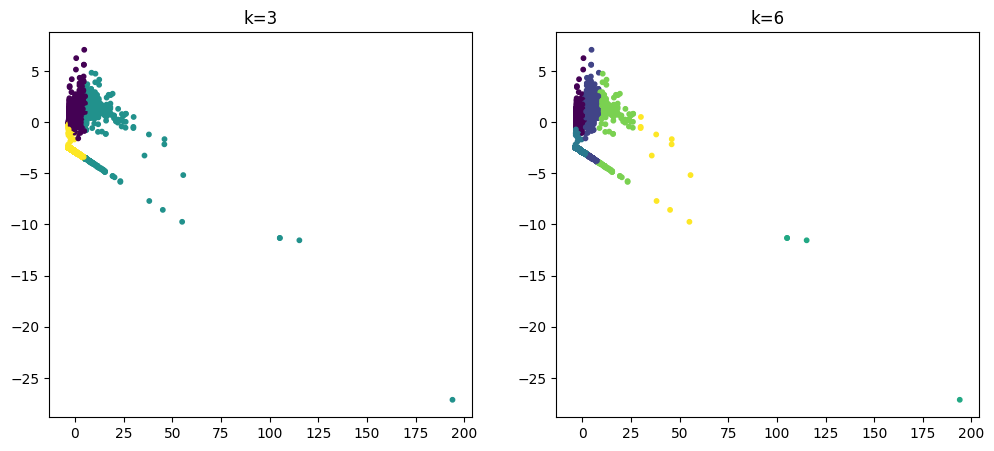

In [6]:
# Step 4: PCA Visualization
# Reduce for visualization
pca = PCA(n_components=2)
X2 = pca.fit_transform(X)

fig, ax = plt.subplots(1, 2, figsize=(12,5))

for i, k in enumerate([3, 6]):
    km = KMeans(n_clusters=k, n_init='auto', random_state=42)
    labels = km.fit_predict(X)
    ax[i].scatter(X2[:,0], X2[:,1], c=labels, s=10)
    ax[i].set_title(f'k={k}')

plt.show()
